In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Install required packages.
import os
import torch
from tqdm import tqdm
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

#!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
#!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
#!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.12.1+cu102


In [12]:
import torch
from greycdata.datasets import GreycDataset

dataset = GreycDataset(name='Acyclic',root='data/Acyclic')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[100]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')
print(data.x)


Processing...



Dataset: GreycDataset(183):
Number of graphs: 183
Number of features: 15
Number of classes: 148

Data(edge_index=[2, 16], bond_type=[16], bond_stereo=[16], x=[9, 15], y=[1])
Number of nodes: 9
Number of edges: 16
Average node degree: 1.78
Has isolated nodes: False
Has self-loops: False
Is undirected: True
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.]])


Done!


In [13]:
#torch.manual_seed(12345)
dataset = dataset.shuffle()

size_train = 130
size_test = len(dataset)-size_train
train_dataset = dataset[:size_train]
test_dataset = dataset[size_train:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 130
Number of test graphs: 53


## Mini-batching of graphs

Since graphs in graph classification datasets are usually small, a good idea is to **batch the graphs** before inputting them into a Graph Neural Network to guarantee full GPU utilization.
In the image or language domain, this procedure is typically achieved by **rescaling** or **padding** each example into a set of equally-sized shapes, and examples are then grouped in an additional dimension.
The length of this dimension is then equal to the number of examples grouped in a mini-batch and is typically referred to as the `batch_size`.

However, for GNNs the two approaches described above are either not feasible or may result in a lot of unnecessary memory consumption.
Therefore, PyTorch Geometric opts for another approach to achieve parallelization across a number of examples. Here, adjacency matrices are stacked in a diagonal fashion (creating a giant graph that holds multiple isolated subgraphs), and node and target features are simply concatenated in the node dimension:

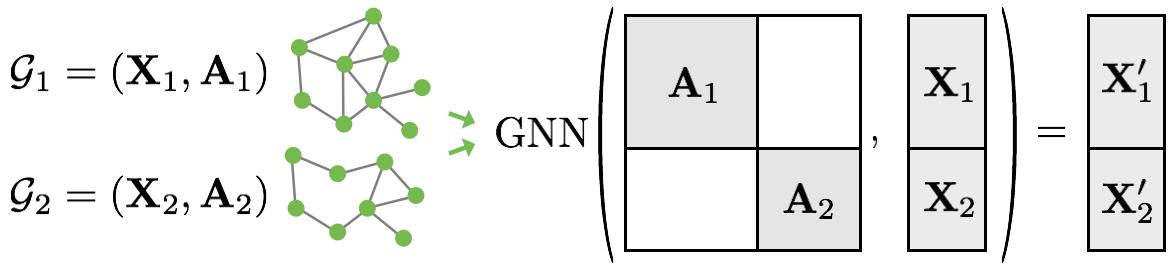

This procedure has some crucial advantages over other batching procedures:

1. GNN operators that rely on a message passing scheme do not need to be modified since messages are not exchanged between two nodes that belong to different graphs.

2. There is no computational or memory overhead since adjacency matrices are saved in a sparse fashion holding only non-zero entries, *i.e.*, the edges.

PyTorch Geometric automatically takes care of **batching multiple graphs into a single giant graph** with the help of the [`torch_geometric.data.DataLoader`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.DataLoader) class:

In [14]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(dataset[0].y)
for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

tensor([186.8000])
Step 1:
Number of graphs in the current batch: 16
DataBatch(edge_index=[2, 212], bond_type=[212], bond_stereo=[212], x=[122, 15], y=[16], batch=[122], ptr=[17])

Step 2:
Number of graphs in the current batch: 16
DataBatch(edge_index=[2, 232], bond_type=[232], bond_stereo=[232], x=[132, 15], y=[16], batch=[132], ptr=[17])

Step 3:
Number of graphs in the current batch: 16
DataBatch(edge_index=[2, 204], bond_type=[204], bond_stereo=[204], x=[118, 15], y=[16], batch=[118], ptr=[17])

Step 4:
Number of graphs in the current batch: 16
DataBatch(edge_index=[2, 244], bond_type=[244], bond_stereo=[244], x=[138, 15], y=[16], batch=[138], ptr=[17])

Step 5:
Number of graphs in the current batch: 16
DataBatch(edge_index=[2, 228], bond_type=[228], bond_stereo=[228], x=[130, 15], y=[16], batch=[130], ptr=[17])

Step 6:
Number of graphs in the current batch: 16
DataBatch(edge_index=[2, 230], bond_type=[230], bond_stereo=[230], x=[131, 15], y=[16], batch=[131], ptr=[17])

Step 7:
N

Here, we opt for a `batch_size` of 64, leading to 3 (randomly shuffled) mini-batches, containing all $2 \cdot 64+22 = 150$ graphs.

Furthermore, each `Batch` object is equipped with a **`batch` vector**, which maps each node to its respective graph in the batch:

$$
\textrm{batch} = [ 0, \ldots, 0, 1, \ldots, 1, 2, \ldots ]
$$

## Training a Graph Neural Network (GNN)

Training a GNN for graph classification usually follows a simple recipe:

1. Embed each node by performing multiple rounds of message passing
2. Aggregate node embeddings into a unified graph embedding (**readout layer**)
3. Train a final classifier on the graph embedding

There exists multiple **readout layers** in literature, but the most common one is to simply take the average of node embeddings:

$$
\mathbf{x}_{\mathcal{G}} = \frac{1}{|\mathcal{V}|} \sum_{v \in \mathcal{V}} \mathcal{x}^{(L)}_v
$$

PyTorch Geometric provides this functionality via [`torch_geometric.nn.global_mean_pool`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.glob.global_mean_pool), which takes in the node embeddings of all nodes in the mini-batch and the assignment vector `batch` to compute a graph embedding of size `[batch_size, hidden_channels]` for each graph in the batch.

The final architecture for applying GNNs to the task of graph classification then looks as follows and allows for complete end-to-end training:

In [15]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_add_pool


class GCN(torch.nn.Module):
    def __init__(self, input_channels,hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(input_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 1)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_add_pool(x, batch)  # [batch_size, hidden_channels]
        # 3. Apply a final classifier
        #x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        return x

model = GCN(input_channels=15,hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(15, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=1, bias=True)
)


Here, we again make use of the [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv) with $\mathrm{ReLU}(x) = \max(x, 0)$ activation for obtaining localized node embeddings, before we apply our final classifier on top of a graph readout layer.

Let's train our network for a few epochs to see how well it performs on the training as well as test set:

In [16]:
model = GCN(input_channels=15,hidden_channels=128)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss(reduction="mean")

def my_mse(gt,pred):
    return ((gt-pred)**2).sum()

def train():
    model.train()
    loss_epoch = 0.0
    for data in train_loader:  # Iterate in batches over the training dataset.
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y.reshape(-1,1))  # Compute the loss.
        loss_epoch += loss.item()
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
        loss_epoch += loss.item()
    return loss_epoch

def test(loader):
    model.eval()
    sse = 0.0
    nb = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index, data.batch)  
        sse += my_mse(out, data.y.reshape(-1,1))
        nb += len(data)
    return sse#/nb  

losses=[]

for epoch in tqdm(range(1, 1000)):
    loss = train()
    losses.append(loss)
    #train_acc = test(train_loader)
    #test_acc = test(test_loader)
    #print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')#',Train Acc: {train_acc:.4f}')#', Test Acc: {test_acc:.4f}')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:56<00:00, 17.74it/s]


1546.2686004638672
10117.66796875


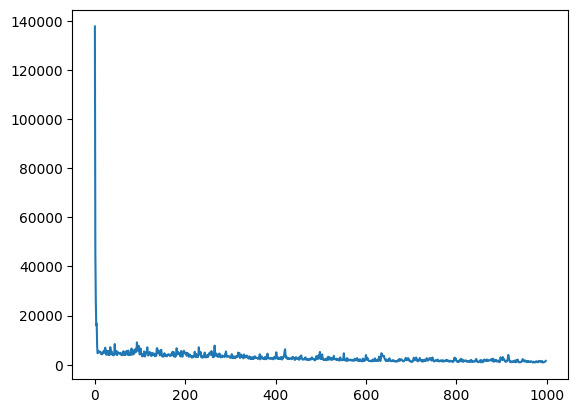

In [17]:
import matplotlib.pyplot as plt
plt.plot(losses)
print(losses[-1])

print(test(train_loader).item())

In [19]:
import numpy as np
gt = np.zeros(len(dataset))
pred = np.zeros(len(dataset))
for i,data in enumerate(dataset):
    pred[i] = model(data.x, data.edge_index, torch.tensor([0])).item()
    gt[i] = data.y.item()

87.36791924053199


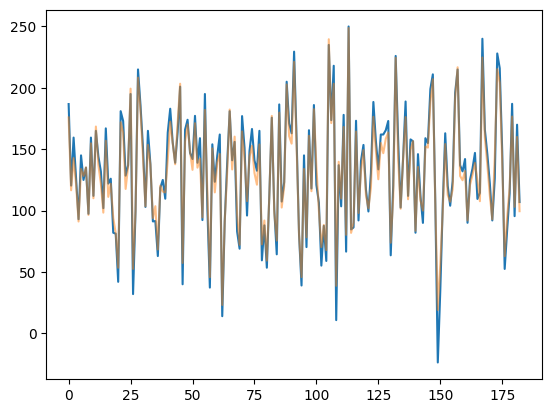

In [20]:
plt.plot(gt)
plt.plot(pred,alpha=.5)
print(np.mean((gt-pred)**2))

In [23]:
pred=np.zeros(size_train)
gt=np.zeros(size_train)
for i,data in enumerate(train_dataset):
    pred[i] = model(data.x, data.edge_index, torch.tensor([0])).item()
    gt[i] = data.y.item()
print(np.sqrt(np.mean((gt-pred)**2)))

8.82202966950904


In [24]:
pred=np.zeros(size_test)
gt=np.zeros(size_test)
for i,data in enumerate(test_dataset):
    pred[i] = model(data.x, data.edge_index, torch.tensor([0])).item()
    gt[i] = data.y.item()
print(np.sqrt(np.mean((gt-pred)**2)))

10.52460033513274


(array([16., 14., 17.,  3.,  2.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.07893372,  4.34811096,  8.61728821, 12.88646545, 17.1556427 ,
        21.42481995, 25.69399719, 29.96317444, 34.23235168, 38.50152893,
        42.77070618]),
 <BarContainer object of 10 artists>)

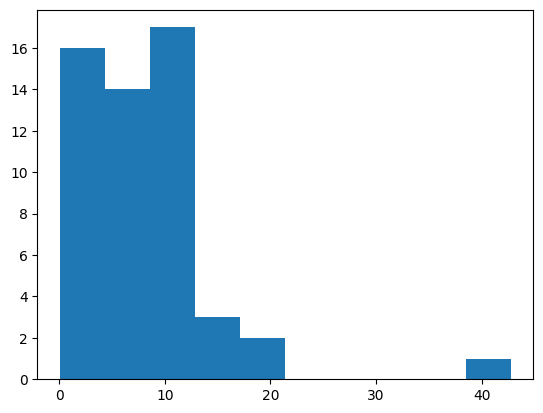

In [25]:
plt.hist(np.abs(gt-pred))